# **TAXI RIDES ANALYSIS**

In this project I will analyze taxi rides for Zuber, a new ride-sharing company that's launching in Chicago. 

The data is composed of 4 tables, with information on the rides, the cabs, the neighborhoods and the weather conditions. These are parsed from the web and collected via SQL queries.

The main goal is to understand passenger preferences and the impact of external factors on rides. In particular, after collecting the data and some exploratory data analysis, I test the hypothesis that the duration of rides from the the Loop to O'Hare International Airport changes on rainy Sundays.

# Importing libraries

In [1]:
# Importing the required libraries
import requests # For sending data requests to website servers using the HTTP data transfer protocol
from bs4 import BeautifulSoup # For turning HTML documents into a tree structure

import numpy as np # For mathematical tools, especially arrays
import pandas as pd # For general data analysis tools
from scipy import stats as st # For statistical tools

import matplotlib.pyplot as plt # For 2D plotting

# Selecting runtime type

In [2]:
# Selecting the type of runtime

# Three types of runtimes are supported:
# 1 - A local runtime
# 2 - A hosted runtime on the Yandex interactive platform
# 3 - A hosted runtime on Google colaboratory
runtime_type = 2

# Setting filepaths
filepath_yandex = '/datasets/'
filepath_google_colab = '/content/drive/My Drive/Colab Notebooks/Yandex Practicum/'

# Connecting to Google drive if needed
if runtime_type == 3:
    print('Mounting Google drive.\n')
    from google.colab import drive # For integration of files with Google drive
    drive.mount('/content/drive') # Mounting Google drive

Mounting Google drive.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Parsing webpage data

## Sending data request

In [3]:
# Parsing data on weather in Chicago in November 2017 from a specific website
URL = 'https://code.s3.yandex.net/data-analyst-eng/chicago_weather_2017.html'

# Requesting the webpage using its URL
req = requests.get(url=URL)

## Converting response to data frame

In [4]:
# Generating a tree structure for the webpage
soup = BeautifulSoup(req.text, 'lxml')
# table = soup.find_all("table", attrs={"id": "weather_records"})

# Parsing the table headings
table_headings = []  # List where the names of the columns will be stored
for row in soup.find_all('th'):
    # The names of the columns are inside <th> elements,
    # so we'll find all <th> elements in the table and run them through in a loop
    table_headings.append(row.text)

# Parsing the table elements beneath the headings
content = []
for row in soup.find_all('tr'):
    # Each row is wrapped in a <tr> tag, we need to loop through all the rows
    if not row.find_all('th'):
        # Ignoring the first row of the table, with headings
        content.append([element.text for element in row.find_all('td')])
        # Within each row the cell content is wrapped in <td> </td> tags
        # We need to loop through all <td> elements, extract the content from the cells, and add it to the list
        # Then add each of the lists to the content list

# Creating a data frame with the parsed webpage data
weather_records = pd.DataFrame(content, columns=table_headings)
print(weather_records)

           Date and time Temperature       Description
0    2017-11-01 00:00:00     276.150     broken clouds
1    2017-11-01 01:00:00     275.700  scattered clouds
2    2017-11-01 02:00:00     275.610   overcast clouds
3    2017-11-01 03:00:00     275.350     broken clouds
4    2017-11-01 04:00:00     275.240     broken clouds
..                   ...         ...               ...
692  2017-11-29 20:00:00     281.340        few clouds
693  2017-11-29 21:00:00     281.690      sky is clear
694  2017-11-29 22:00:00     281.070        few clouds
695  2017-11-29 23:00:00     280.060      sky is clear
696  2017-11-30 00:00:00     278.460      sky is clear

[697 rows x 3 columns]


# Analyzing data with SQL

## Exploratory data analysis

The goal of this section is to explore the tables in the database.

Finding the number of taxi rides for each taxi company for November 15-16, 2017.
* I name the resulting field trips_amount and print it along with the company_name field.
* I sort the results by the trips_amount field in descending order.

In [5]:
# SELECT
#     cabs.company_name,
#     COUNT(trips.trip_id) AS trips_amount
# FROM
#     cabs
#     INNER JOIN trips ON cabs.cab_id = trips.cab_id
# WHERE
#     trips.start_ts::date BETWEEN '2017-11-15' AND '2017-11-16'
# GROUP BY
#     cabs.company_name
# ORDER BY
#     trips_amount DESC;

Finding the number of rides for every taxi company whose name contains the words "Yellow" or "Blue" for November 1-7, 2017.
* I name the resulting variable trips_amount.
* I group the results by the company_name field.

In [6]:
# SELECT
#     cabs.company_name,
#     COUNT(trips.trip_id) AS trips_amount
# FROM
#     trips
#     INNER JOIN cabs ON trips.cab_id = cabs.cab_id
# WHERE
#     (cabs.company_name LIKE '%Yellow%'
#     OR cabs.company_name LIKE '%Blue%')
#     AND trips.start_ts::date BETWEEN '2017-11-01' AND '2017-11-07'
# GROUP BY
#     cabs.company_name;

In November 2017, the most popular taxi companies were Flash Cab and Taxi Affiliation Services. I will now find the number of rides for these two companies and name the resulting variable trips_amount.
* I join the rides for all other companies in the group "Other".
* I group the data by taxi company names.
* I name the field with taxi company names company.
* I sort the result in descending order by trips_amount.

In [7]:
# SELECT
#     CASE WHEN cabs.company_name NOT IN ('Flash Cab', 'Taxi Affiliation Services') THEN 'Other'
#     ELSE cabs.company_name
#     END AS company,
#     COUNT(trips.trip_id) AS trips_amount
# FROM
#     trips
#     INNER JOIN cabs ON trips.cab_id = cabs.cab_id
# WHERE
#     trips.start_ts::date BETWEEN '2017-11-01' AND '2017-11-07'
# GROUP BY
#     company
# ORDER BY
#     trips_amount DESC;

## Testing hypotheses

The goal of this section is to collect data that would help test the hypothesis that the duration of rides from the the Loop to O'Hare International Airport changes on rainy Sundays.

I start by retrieving the identifiers of the O'Hare and Loop neighborhoods from the neighborhoods table.

In [8]:
# SELECT
#     neighborhoods.neighborhood_id,
#     neighborhoods.name AS name
# FROM
#     neighborhoods
# WHERE
#     name LIKE '%Hare' OR name LIKE 'Loop';

For each hour, retrieving the weather condition records from the weather_records table.
* Using the CASE operator, I break all hours into two groups: "Bad" if the description field contains the words "rain" or "storm," and "Good" for others. I name the resulting field weather_conditions.
* The final table will include two fields: date and hour (ts) and weather_conditions.

In [9]:
# SELECT
#     weather_records.ts,
#     CASE WHEN weather_records.description LIKE '%rain%' OR weather_records.description LIKE '%storm%'
#     THEN 'Bad'
#     ELSE 'Good'
#     END AS weather_conditions
# FROM
#     weather_records;

Printing the desired rides, their duration and the weather conditions.
* I retrieve from the trips table all the rides that started in the Loop (neighborhood_id: 50) and ended at O'Hare (neighborhood_id: 63) on a Sunday.
* I get the weather conditions for each ride using the method I applied in the previous task.
* Also, I retrieve the duration of each ride.
* I ignore rides for which data on weather conditions is not available.

In [10]:
# SELECT
#     start_ts,
#     CASE WHEN weather_records.description LIKE '%rain%' OR weather_records.description LIKE '%storm%'
#     THEN 'Bad'
#     ELSE 'Good'
#     END AS weather_conditions,
#     duration_seconds
# FROM
#     trips
#     INNER JOIN weather_records ON trips.start_ts = weather_records.ts
# WHERE
#     trips.pickup_location_id = 50
#     AND trips.dropoff_location_id = 63
#     AND EXTRACT('isodow' FROM trips.start_ts) = 6
# ORDER BY
#     trip_id;

# Analyzing data with Python

## Loading CSV data

In [11]:
# Loading the data files
if runtime_type == 1:
    print('A local runtime was chosen.\n')
    data_1 = pd.read_csv('project_sql_result_01.csv')
    data_2 = pd.read_csv('project_sql_result_04.csv')
    data_3 = pd.read_csv('project_sql_result_07.csv')

elif runtime_type == 2:
    print('A hosted runtime on Yandex interactive platform was chosen.\n')
    data_1 = pd.read_csv(filepath_yandex + 'project_sql_result_01.csv')
    data_2 = pd.read_csv(filepath_yandex + 'project_sql_result_04.csv')
    data_3 = pd.read_csv(filepath_yandex + 'project_sql_result_07.csv')

elif runtime_type == 3:
    print('A hosted runtime on Google colaboratory was chosen.\n')
    data_1 = pd.read_csv(filepath_google_colab + 'project_sql_result_01.csv')
    data_2 = pd.read_csv(filepath_google_colab + 'project_sql_result_04.csv')
    data_3 = pd.read_csv(filepath_google_colab + 'project_sql_result_07.csv')

else:
    print('Incorrect selection of a runtime type! Please set "runtime_type" to either "1", "2" or "3".')

A hosted runtime on Google colaboratory was chosen.



## Exploratory data analysis

### Exploring first data set

In [12]:
# Looking at the general information of the 1st data set
print('Printing the general information:\n')
data_1.info()

print('Printing some of the first rows:\n')
display(data_1.head(10))

Printing the general information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   company_name  64 non-null     object
 1   trips_amount  64 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB
Printing some of the first rows:



,company_name,trips_amount
0,Flash Cab,19558
1,Taxi Affiliation Services,11422
2,Medallion Leasin,10367
3,Yellow Cab,9888
4,Taxi Affiliation Service Yellow,9299
5,Chicago Carriage Cab Corp,9181
6,City Service,8448
7,Sun Taxi,7701
8,Star North Management LLC,7455
9,Blue Ribbon Taxi Association Inc.,5953


In [13]:
# Exploring the "company_name" column
print('Exploring the "company_name" column.\n')
print('The number of rows is: {}'.format(len(data_1['company_name'])) )
print('The number of unique company names is: {}'.format(len(data_1['company_name'].unique())) )

Exploring the "company_name" column.

The number of rows is: 64
The number of unique company names is: 64


Exploring the "trips_amount" column.

count       64.000000
mean      2145.484375
std       3812.310186
min          2.000000
25%         20.750000
50%        178.500000
75%       2106.500000
max      19558.000000
Name: trips_amount, dtype: float64 



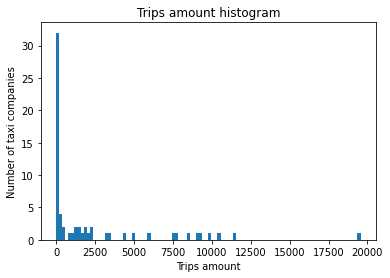

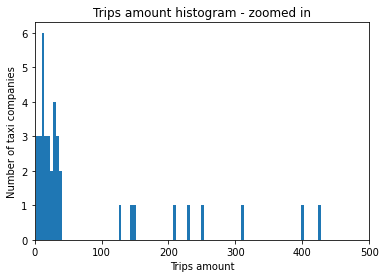

In [14]:
# Exploring the "trips_amount" column
print('Exploring the "trips_amount" column.\n')
print(data_1['trips_amount'].describe(), '\n')

data_1['trips_amount'].plot(kind='hist', bins=100, title='Trips amount histogram')
plt.ylabel('Number of taxi companies')
plt.xlabel('Trips amount')
plt.show()

top_lim = 500
data_1.query('trips_amount <= @top_lim')['trips_amount'].plot(kind='hist', bins=100, title='Trips amount histogram - zoomed in')
plt.ylabel('Number of taxi companies')
plt.xlabel('Trips amount')
plt.xlim((0,top_lim))
plt.show()

### Conclusions

From the histogram of the amount of trips, we see that the distribution is peaked under about 50 trips, indicating that a large amount of taxi companies have a low amount of trips. High amounts of trips are uncommon, but the few companies that are popular are extremely popular, where the maximal amount of trips that a company has reaches to about 20,000. This is expressed in the distribution being very positively-skewed.

### Exploring second data set

In [15]:
# Looking at the general information of the 2nd data set
print('Printing the general information:\n')
data_2.info()

print('Printing some of the first rows:\n')
display(data_2.head(10))

Printing the general information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dropoff_location_name  94 non-null     object 
 1   average_trips          94 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.6+ KB
Printing some of the first rows:



,dropoff_location_name,average_trips
0,Loop,10727.466667
1,River North,9523.666667
2,Streeterville,6664.666667
3,West Loop,5163.666667
4,O'Hare,2546.900000
5,Lake View,2420.966667
6,Grant Park,2068.533333
7,Museum Campus,1510.000000
8,Gold Coast,1364.233333
9,Sheffield & DePaul,1259.766667


In [16]:
# Exploring the "dropoff_location_name" column
print('Exploring the "dropoff_location_name" column.\n')
print('The number of rows is: {}'.format(len(data_2['dropoff_location_name'])) )
print('The number of unique company names is: {}'.format(len(data_2['dropoff_location_name'].unique())) )

Exploring the "dropoff_location_name" column.

The number of rows is: 94
The number of unique company names is: 94


Exploring the "average_trips" column.

count       94.000000
mean       599.953728
std       1714.591098
min          1.800000
25%         14.266667
50%         52.016667
75%        298.858333
max      10727.466667
Name: average_trips, dtype: float64 



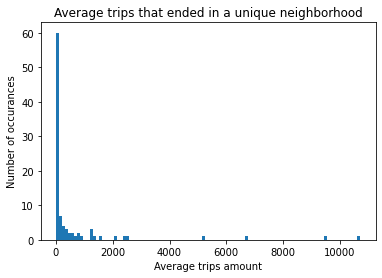

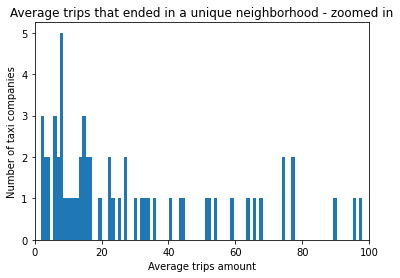

In [17]:
# Exploring the "average_trips" column
print('Exploring the "average_trips" column.\n')
print(data_2['average_trips'].describe(), '\n')

data_2['average_trips'].plot(kind='hist', bins=100, title='Average trips that ended in a unique neighborhood')
plt.ylabel('Number of occurances')
plt.xlabel('Average trips amount')
plt.show()

top_lim = 100
data_2.query('average_trips <= @top_lim')['average_trips'] \
            .plot(kind='hist', bins=100, title='Average trips that ended in a unique neighborhood - zoomed in')
plt.ylabel('Number of taxi companies')
plt.xlabel('Average trips amount')
plt.xlim((0,top_lim))
plt.show()

### Conclusions

From the histogram of the average amount of trips that ended in a unique neighborhood, we see that the distribution is peaked around about 10 trips. This shows that many neighborhoods have a low amount of trips to them. High amounts of trips are uncommon, but the few neighborhoods that are popular are extremely popular, where the maximal average amount of trips that a neighborhood has is reaches to about 10,000. This is expressed in the distribution being very positively-skewed.

### Treating data types

In [18]:
# Presenting the data types of the first data frame
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   company_name  64 non-null     object
 1   trips_amount  64 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [19]:
# Presenting the data types of the second data frame
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dropoff_location_name  94 non-null     object 
 1   average_trips          94 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.6+ KB


### Conclusions

All of the different variables have correct data types:
* company_name should be a string.
* trips_amount should be an integer.
* dropoff_location_name should be a string.
* average_trips should be a real number.

### Analyzing taxi companies

The top 10 taxi companies in terms of amount of rides are:
Flash Cab, Taxi Affiliation Services, Medallion Leasin, Yellow Cab, Taxi Affiliation Service Yellow, Chicago Carriage Cab Corp, City Service, Sun Taxi, Star North Management LLC, Blue Ribbon Taxi Association Inc.

Plotting the amount of rides for the top 10 taxi companies:



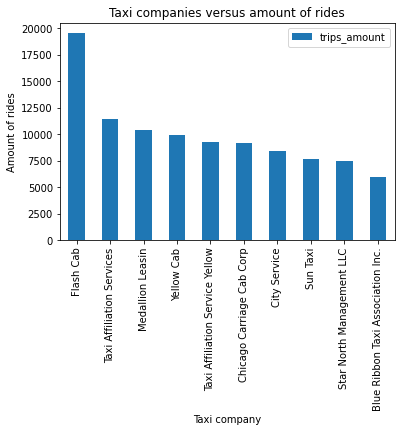


Plotting the amount of rides for all of the taxi companies:



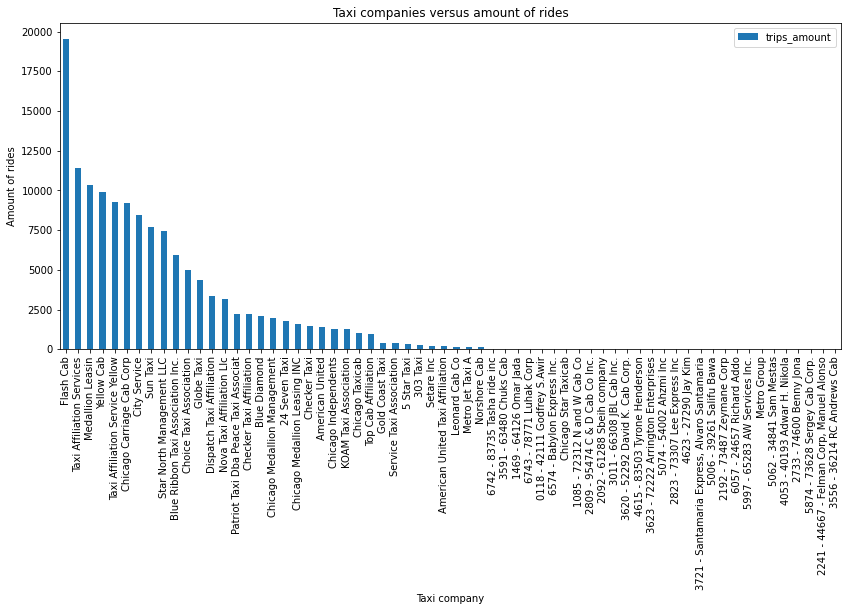

In [20]:
# Plotting the amount of rides for the top taxi companies
num_top = 10 # Amount of top taxi companies to find
top_companies = data_1.loc[0:num_top-1, :] # A data frame
top_companies = top_companies.set_index('company_name')

print('The top {} taxi companies in terms of amount of rides are:\n{}\n'
      .format(num_top, ', '.join(top_companies.index.values)))

print('Plotting the amount of rides for the top {} taxi companies:\n'
      .format(num_top))
top_companies.plot(kind='bar')
plt.title('Taxi companies versus amount of rides'.format(num_top))
plt.ylabel('Amount of rides')
plt.xlabel('Taxi company')
plt.show()
print()

# Plotting the amount of rides for all of the taxi companies
print('Plotting the amount of rides for all of the taxi companies:\n')
data_1.set_index('company_name').plot(kind='bar', figsize=(14,6))
plt.title('Taxi companies versus amount of rides')
plt.ylabel('Amount of rides')
plt.xlabel('Taxi company')
plt.show()

In [21]:
# Calculating the rides share of the top taxi company
top_company_name = data_1.loc[0,'company_name']
top_company_share = 100 * data_1.loc[0,'trips_amount'] / data_1['trips_amount'].sum()

print('The top taxi company, "{}", is used in {:.2f}% of the rides.' \
      .format(top_company_name, top_company_share))

The top taxi company, "Flash Cab", is used in 14.24% of the rides.


### Conclusions

We can see that the amount of rides per taxi company is decreasing monotonically, where big shares of the rides belongs to a few companies. In particular, the top taxi company, "Flash Cab", is used in 14.24% of the rides, and has almost twice as many rides as each of the next few top companies has.

This can be explained by a snowball effect, in which when a company becomes popular, it's popularity will increase faster than that of an unpopular or new company. That can result from the popular company having more funds for advertisement and for supporting more taxis.

### Analyzing drop-off neighborhoods

The top 10 neighborhoods in terms of drop-offs are:
Loop, River North, Streeterville, West Loop, O'Hare, Lake View, Grant Park, Museum Campus, Gold Coast, Sheffield & DePaul



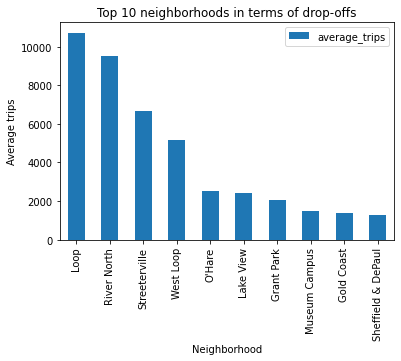

In [22]:
# Identifying the top 10 neighborhoods in terms of drop-offs
num_top = 10 # Amount of top neighborhoods to find
top_neighborhoods = data_2.loc[0:num_top-1, :] # A data frame
top_neighborhoods = top_neighborhoods.set_index('dropoff_location_name')

# Presenting results
print('The top {} neighborhoods in terms of drop-offs are:\n{}\n'
      .format(num_top, ', '.join(top_neighborhoods.index.values)))

top_neighborhoods.plot(kind='bar')
plt.title('Top {} neighborhoods in terms of drop-offs'.format(num_top))
plt.ylabel('Average trips')
plt.xlabel('Neighborhood')
plt.show()

### Conclusions

We can see that the average amount of rides per neighborhood destination is decreasing monotonically, where the few first top neighborhoods get almost twice as many rides to them relative to the other neighborhoods.

This can be explained as follows:
* Perhaps some neighborhoods have more financial, educational or cultural activity than other, more residential neighborhoods. As a result, these places would attract more traffic to them.
* Another possible property of popular destinations is their distance from places that attract people - far locations make it more likely for their residents to use transportation.
* Another possibility is that the residents of the popular neighborhoods may have higher incomes, which allows them to pay for taxis more often, rather than use public transportation.
* Another factor that can cause a neighborhood to get more traffic are its geographic and population sizes, where larger sizes raise the probability of getting more traffic.
* Finally, popular neighborhoods might simply have less public transportation to them, which makes taxi rides a necessity.

## Testing hypotheses

### Impact of weather on rides

Testing the hypothesis that the average duration of rides from the Loop to O'Hare International Airport changes on rainy Saturdays.

In [23]:
# Looking at the general information of the relevant data frame
print('Printing the general information:\n')
data_3.info()

print('Printing some of the first rows:\n')
display(data_3.head(10))

Printing the general information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   start_ts            1068 non-null   object 
 1   weather_conditions  1068 non-null   object 
 2   duration_seconds    1068 non-null   float64
dtypes: float64(1), object(2)
memory usage: 25.2+ KB
Printing some of the first rows:



,start_ts,weather_conditions,duration_seconds
0,2017-11-25 16:00:00,Good,2410.0
1,2017-11-25 14:00:00,Good,1920.0
2,2017-11-25 12:00:00,Good,1543.0
3,2017-11-04 10:00:00,Good,2512.0
4,2017-11-11 07:00:00,Good,1440.0
5,2017-11-11 04:00:00,Good,1320.0
6,2017-11-04 16:00:00,Bad,2969.0
7,2017-11-18 11:00:00,Good,2280.0
8,2017-11-11 14:00:00,Good,2460.0
9,2017-11-11 12:00:00,Good,2040.0


In [24]:
# Creating the samples for testing
sample_good_weather = data_3.query('weather_conditions == "Good"')['duration_seconds']
sample_bad_weather = data_3.query('weather_conditions == "Bad"')['duration_seconds']

# Exploring the samples
print('Printing statistics of the average duration of rides when the weather is good:\n',
      sample_good_weather.describe(), '\n')

print('Printing statistics of the average duration of rides when the weather is bad:\n',
      sample_bad_weather.describe())

Printing statistics of the average duration of rides when the weather is good:
 count     888.000000
mean     1999.675676
std       759.198268
min         0.000000
25%      1389.750000
50%      1800.000000
75%      2460.000000
max      7440.000000
Name: duration_seconds, dtype: float64 

Printing statistics of the average duration of rides when the weather is bad:
 count     180.000000
mean     2427.205556
std       721.314138
min       480.000000
25%      1962.000000
50%      2540.000000
75%      2928.000000
max      4980.000000
Name: duration_seconds, dtype: float64


We can see a mean difference between the mean ride durations of about 400 seconds, with similar standard deviations, where the rides are longer on average on rainy days. The difference between the medians is even greater.

In [25]:
# Testing the hyopthesis
print('The null hypothesis is that the average duration of rides from the Loop '
      'to O\'Hare International Airport on Saturdays with and without rain are the same.')
print('The alternative hypothesis is that the average duration of rides from the Loop '
      'to O\'Hare International Airport on Saturdays with and without rain are different.')

alpha = 0.05 # The critical statistical significance level
results = st.ttest_ind(sample_good_weather, sample_bad_weather, equal_var=False)
print('The critical statistical significance level: {:.3f}'.format(alpha))
print('The p-value is: {:.3f}'.format(results.pvalue))

if results.pvalue < alpha: # If the p-value is less than the critical statistical significance level
    print("The null hypothesis is rejected.")
else:
    print("The null hypothesis can't be rejected.")

The null hypothesis is that the average duration of rides from the Loop to O'Hare International Airport on Saturdays with and without rain are the same.
The alternative hypothesis is that the average duration of rides from the Loop to O'Hare International Airport on Saturdays with and without rain are different.
The critical statistical significance level: 0.050
The p-value is: 0.000
The null hypothesis is rejected.


### Conclusions

I have formulated the hypotheses as follows:
- Null hypothesis: The average duration of rides from the Loop to O'Hare International Airport on Saturdays with and without rain are the same.
- Alternative hypothesis: The average duration of rides from the Loop to O'Hare International Airport on Saturdays with and without rain are different.

The hypotheses were formulated like so because when investigating whether a difference exists between populations, the null hypothesis should be formulated with an equality sign.

The criteria I used to test the hypotheses is an alpha value of 5% and non-equal population variances. I used this critical value because it's a relatively low and commonly used value. I assumed the variances of the original populations of the samples are different, since these populations don't have to have similar properties. In particular, the weather conditions are opposite, which can affect the willingness of the riders to extend their rides or call a cab in the first place.

The result of the test is that the null hypothesis is rejected - we reject the hypothesis that the average duration of rides from the Loop to O'Hare International Airport on Saturdays with and without rain are the same.

This result can be explained by the fact that a worse weather can affect both the riders and the taxi. More riders would prefer to use a cab than travel in bad weather conditions, the driving itself will be slower for safety reasons, and more traffic jams may occur when there's more traffic. All of these will increase the mean ride duration.

# Overall conclusions

The overall conclusions from the main steps of the analysis are:
- The top 10 taxi companies in terms of amount of rides are:
Flash Cab, Taxi Affiliation Services, Medallion Leasin, Yellow Cab, Taxi Affiliation Service Yellow, Chicago Carriage Cab Corp, City Service, Sun Taxi, Star North Management LLC, Blue Ribbon Taxi Association Inc.
- The amount of rides per taxi company is decreasing monotonically, where big shares of the rides belongs to a few companies. In particular, the top taxi company, "Flash Cab", is used in 14.24% of the rides, and has almost twice as many rides as each of the next few top companies has.
- The top 10 neighborhoods in terms of drop-offs are:
Loop, River North, Streeterville, West Loop, O'Hare, Lake View, Grant Park, Museum Campus, Gold Coast, Sheffield & DePaul.
- The average amount of rides per neighborhood destination is decreasing monotonically, where the few first top neighborhoods get almost twice as many rides to them relative to the other neighborhoods.
- We reject the hypothesis that the average duration of rides from the Loop to O'Hare International Airport on Saturdays with and without rain are the same.

The overall business insights that I can suggest to the taxi companies are:
- To improve the availability of the service and manage the workload, improve the ability to transport passengers to the top few neighborhoods, and increase the available number of drivers and call operators on rainy days.
- To increase the profits, follow the business models of the top few companies, prioritize supporting transportation to the top few neighborhoods, and increase the fees on days with bad weather.
- To better estimate the times of arrival, for the use of both the taxi companies and the riders, the ride durations should be evaluated independently on days with good and with bad weathers, where the durations on days with bad weather should be expected to be higher.